In [1]:
import pandas as pd
import numpy as np
import os

import compute

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

font = {'family': 'sans-serif', 'serif' : 'Helvetica',
        'size'   : 25}
plt.rc('font', **font)

my_quali_colormaps = ['colorblind', 'Dark2']

In [3]:
storage = os.environ['MICOM_EXP'] + 'setA_mono_simTime144h/' # on Peregrine
print(storage)

run_status_file = storage + "run_status.tsv"
run_status = pd.read_csv(run_status_file, sep="\t")

rep_simID_dict = run_status.loc[run_status['program_log_doneSim']==1, ['rep_name', 'simID']].groupby('rep_name')['simID'].apply(list).to_dict()

/data/s4278836/First_project/experiments/setA_mono_simTime144h/


In [4]:
rep_simID_check_dict = {x: {rep_simID_dict[x][i]: 1 for i in range(len(rep_simID_dict[x]))} for x in rep_simID_dict.keys()}
rep_simID_df = pd.DataFrame.from_dict(rep_simID_check_dict)
rep_simID_df.sum() 

rep1    36
rep2    36
rep3    36
dtype: int64

For each replicate, if sum returns 36 means all 36 cases (18 species in plastic or non-plastic mode), it means all simulations have sucessfully completed.

Here, all replicates have sum of 36 => All 36 cases were sucessfully replicated 3 times

In [5]:
rep_name_list = rep_simID_df.columns.values
print(rep_name_list)

speciesID_set = set([x.rsplit('_', 1)[0] for x in rep_simID_df.index.values])
print(speciesID_set)

culture_type_list = ['batch', 'continuous']

media = ['EU_avg', 'DACH', 'diabetes2', 
         'gluten_free', 'high_fat', 'high_fiber', 
         'high_protein', 'mediterranean', 'unhealthy', 
         'vegan', 'vegetarian']

['rep1' 'rep2' 'rep3']
{'setA_24', 'setA_3', 'setA_13', 'setA_17', 'setA_20', 'setA_22', 'setA_4', 'setA_21', 'setA_8', 'setA_26', 'setA_16', 'setA_9', 'setA_11', 'setA_6', 'setA_15', 'setA_14', 'setA_18', 'setA_19'}


In [6]:
speciesID = 'setA_6'

max_time = 12.0

flux_dyn = pd.DataFrame()

for rep in rep_name_list:
    for cult in culture_type_list:
        for m in media:
            data_df = compute.flux_dynamics(storage, rep, speciesID, cult, m, tmax=max_time, normalize=True, plot_biomass=False)
            data_df['media'] = m
            data_df['culture_type'] = cult
            data_df['replicate'] = rep

            flux_dyn = pd.concat([flux_dyn, data_df])
    
print(flux_dyn.shape)
flux_dyn.head()

(21519, 7)


t_start     t_end  euclidean_dist  rate_of_change   media culture_type  \
0  0.000000  0.034190             0.0             0.0  EU_avg        batch   
1  0.034190  0.082190             0.0             0.0  EU_avg        batch   
2  0.082190  0.114802             0.0             0.0  EU_avg        batch   
3  0.114802  0.146192             0.0             0.0  EU_avg        batch   
4  0.146192  0.176163             0.0             0.0  EU_avg        batch   

  replicate  
0      rep1  
1      rep1  
2      rep1  
3      rep1  
4      rep1

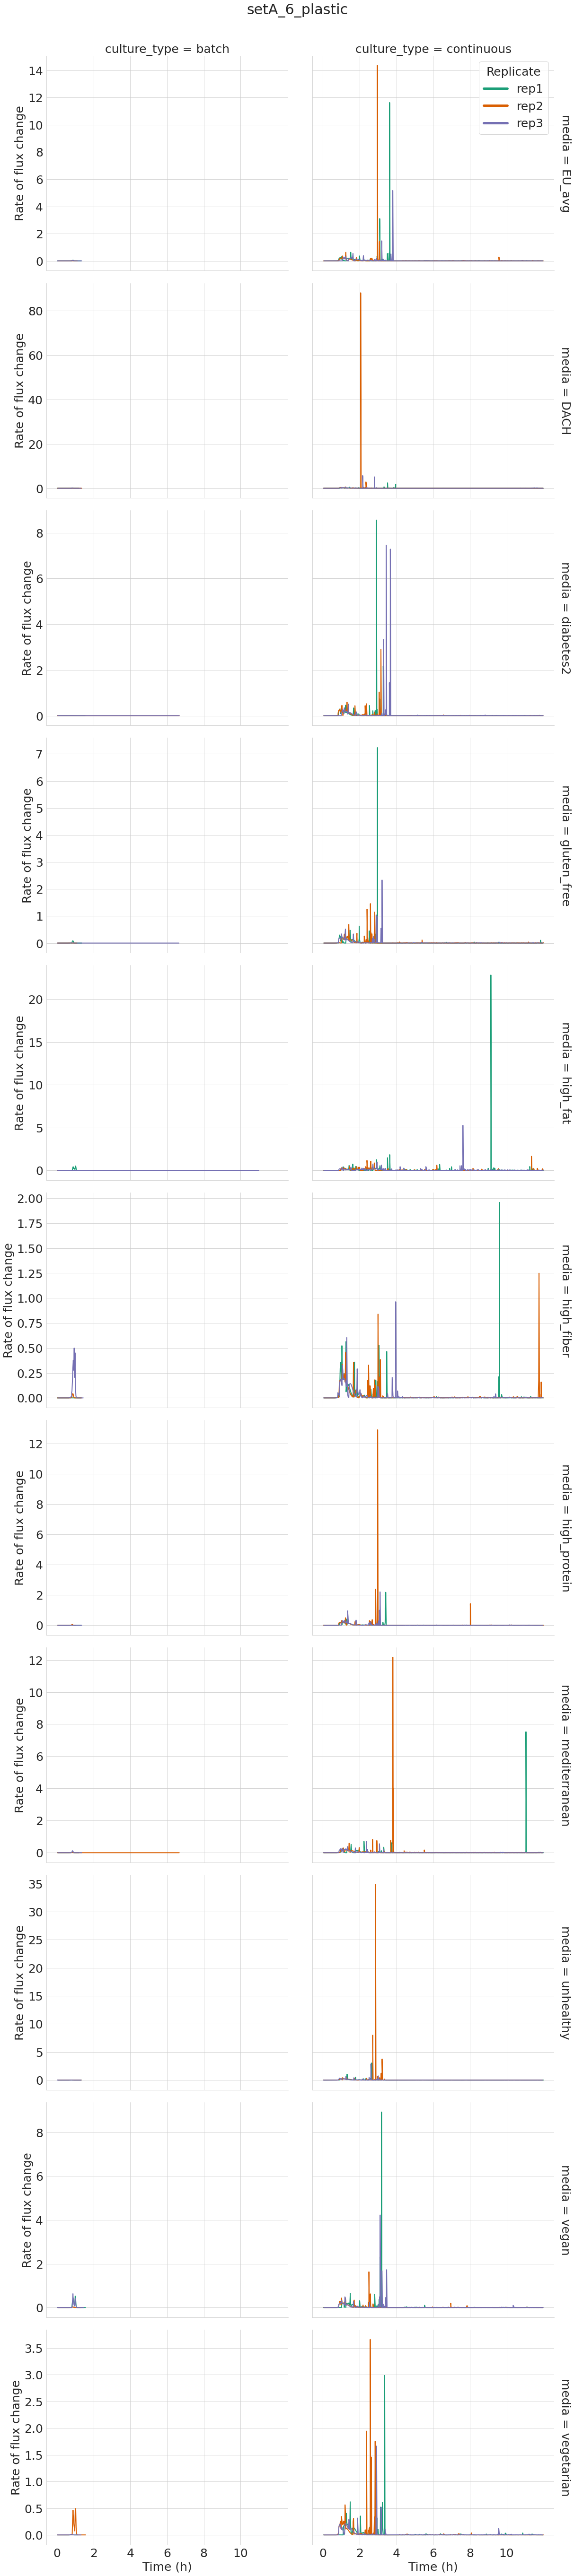

In [7]:
kwargs={'linewidth':2, 'palette': sns.color_palette(my_quali_colormaps[1], len(rep_name_list))}

grid = sns.FacetGrid(data=flux_dyn,  row='media', col='culture_type', sharex=True, sharey='row', 
                     margin_titles=True, legend_out=True, height=7, aspect=1.2)

grid.map_dataframe(sns.lineplot, data=flux_dyn, x='t_end', y='rate_of_change', hue='replicate', **kwargs)

# General settings
grid.fig.subplots_adjust(top=0.96)
grid.fig.suptitle(speciesID + "_plastic", fontsize=30)
grid.set_xlabels("Time (h)")
grid.set_ylabels("Rate of flux change")
# grid.fig.subplots_adjust(wspace=0.2, hspace=0.2)
# grid.fig.set_size_inches(15,17)

# x-axis ticks
if max_time <= 12.0:
    grid.set(xticks=np.arange(0.0, max_time, 2.0))
elif max_time <= 24.0:
    grid.set(xticks=np.arange(0.0, max_time, 6.0))
elif max_time <= 72.0:
    grid.set(xticks=np.arange(0.0, max_time, 12.0))
else:
    grid.set(xticks=np.arange(0.0, max_time, 24.0))

legnd = grid.axes[0,1].legend(loc='upper right', bbox_to_anchor=(1.0, 1.0), title='Replicate')
# Change width of lines in legend
for line in legnd.get_lines():
    line.set_linewidth(5)